# Initialize

In [1]:
# %set_env SCIPY_USE_PROPACK=1

import config

import numpy as np
import ctypes
import sys
from numpy.linalg import lstsq
from numba import jit, njit
import matplotlib.pyplot as plt
import pickle
import struct
import json
import tifffile

from scipy.sparse import *
from scipy.sparse.linalg import lsmr, lsqr, eigs
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import importlib
import FORBILD

importlib.reload(FORBILD)
importlib.reload(config)

from FORBILD import discrete_phantom
from config import *
from operators.operators import *

np.set_printoptions(threshold=sys.maxsize, precision=3, linewidth=480)


def forward_with_matrix(img, mat):
    img = img.reshape(nx*ny, 1)
    mat = mat.reshape(nnp*nu, nx*ny)

    proj = mat @ img

    return proj.reshape(nnp, nu)

def backward_from_projection(sino, mat):
    sino = sino.reshape(nnp*nu, 1)
    mat = mat.reshape(nnp*nu, nx*ny)
    
    img, residual, _, _ = lstsq(mat, sino, rcond=None)

    print("Residual: ", residual)

    return img.reshape(nx, ny)

def backward_from_projection_hex(sino, mat):
    sino = sino.reshape(nnp*nu, 1)
    mat = mat.reshape((nnp*nu, -1))
    
    img, residual, rank, _ = lstsq(mat, sino, rcond=None)

    print("Residual: ", residual, "Rank: ", rank)

    return img

def hex_mat_presolve(mat):
    mat = mat.reshape(nnp*nu, -1)
    mat1 = np.zeros((nnp*nu, nl*nc-np.floor(nl/2).astype(int)), dtype=np.float64)
    pos = pos1 = 0

    for i in range(nl):
        if i%2 == 0:
            mat1[:, pos1:pos1+nc] = mat[:, pos:pos+nc]
            pos1 += nc
            pos += nc
        else:
            mat1[:, pos1:pos1+nc-1] = mat[:, pos:pos+nc-1]
            pos1 += nc-1
            pos += nc
    
    return mat1

def post_process_hex(img):
    img1 = np.zeros((nl, nc), dtype=np.float64)
    pos = 0

    for i in range(nl):
        if i%2 == 0:
            img1[i] = img[pos:pos+nc].ravel()
            pos += nc
        else:
            img1[i, :-1] = img[pos:pos+nc-1].ravel()
            pos += nc-1
    
    return img1

def load_tiff_stack_with_metadata(file):
    '''

    :param file: Path object describing the location of the file
    :return: a numpy array of the volume, a dict with the metadata
    '''
    if not (file.endswith('.tif') or file.endswith('.tiff')):
        raise FileNotFoundError('File has to be tif.')
    with tifffile.TiffFile(file) as tif:
        data = tif.asarray()
        metadata = tif.pages[0].tags["ImageDescription"].value
    metadata = metadata.replace("'", "\"")
    try:
        metadata = json.loads(metadata)
    except:
        print('The tiff file you try to open does not seem to have metadata attached.')
        metadata = None
    return data, metadata

### Old array loader and test

In [2]:
# A_B1_ref_sparse = bsr_array(load_npz("./matrixes/A_B1_ref_sparse_" + str(nx) + '_' + str(ny) + "_" + str(nnp) + "_"+ str(nu) + ".npz"))
# A_B0_sparse = bsr_array(load_npz("./matrixes/A_B0_sparse_" + str(nx) + '_' + str(ny) + "_" + str(nnp) + "_"+ str(nu) + ".npz"))
# A_B1_sparse = bsr_array(load_npz("./matrixes/A_B1_sparse_" + str(nx) + '_' + str(ny) + "_" + str(nnp) + "_"+ str(nu) + ".npz"))
# A_Hl_sparse = bsr_array(load_npz("./matrixes/A_Hl_sparse_" + str(nl) + '_' + str(nc) + "_" + str(nnp) + "_"+ str(nu) + ".npz"))
# A_H0_sparse = bsr_array(load_npz("./matrixes/A_H0_sparse_" + str(H0_nl) + '_' + str(H0_nc) + "_" + str(nnp) + "_"+ str(nu) + ".npz"))

In [3]:
# y2 = A_B1_sparse.sum(axis=1).reshape((nnp, nu))
# y = A_H0_sparse.sum(axis=1).reshape((nnp, nu))

In [4]:
# x = np.arange(nu)

# plt.plot(x, y[0]*dt*dt*1.5/np.sqrt(3))
# plt.plot(x, y2[0]*du*dx, color='r')
# plt.show()

### Pylops Operators

(900, 855) (900,)
32 64 16 8
32 64 16 8


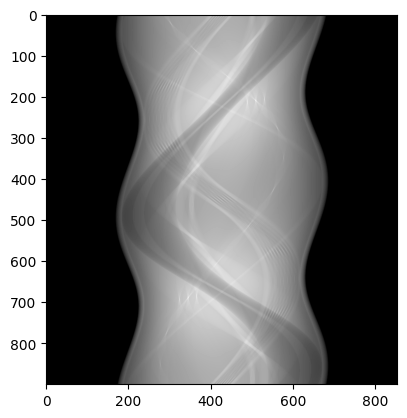

In [2]:
# sino_720_855 = np.load(open('./matrixes/FORBILD_sinogram_720_855.dat', 'rb'))
# sino_180_855 = sino_720_855[0::4]
# sino_1800_1710_noise = np.load(open('./matrixes/FORBILD_sinogram_1800_1710_poisson.dat', 'rb'))
sino_1800_1710_FWHM = np.load(open('./matrixes/FORBILD_sinogram_1800_1710_FWHM_high_contrast.dat', 'rb'))
sino_1800_1710_FWHM_noise = np.load(open('./matrixes/FORBILD_sinogram_1800_1710_FWHM_high_contrast_noise.dat', 'rb'))

nx = ny = 512
dx = dy = 100.0/nx
nnp = 900
nu = 855
du = 25.0/128 * 1710/nu

sino = np.zeros((nnp, nu))
y = int(1710/nu)
x = int(1800/nnp)
for i in range(int(1710/nu)):
    sino += np.exp(sino_1800_1710_FWHM[::x, i::y]) / y

sino = np.log(sino)

lsd = 312.5
lso = 156.25
angles = np.linspace(0, 2*np.pi, sino.shape[0], endpoint=False, dtype=np.float64)

mmax = 1.1
mmin = 0.9

dmax = 0.1
dmin = 0.0
# testID = '512_512_360_1710_poisson_20000'
testID = 'FWHM_Testing_900_855'

print(sino.shape, angles.shape)
plt.imshow(sino, cmap = "gray")

A_B0 = A_B0_operator(nx, ny, nnp, nu, dx, dy, du, lsd, lso, angles)
A_B1 = A_B1_operator(nx, ny, nnp, nu, dx, dy, du, lsd, lso, angles)
A_SF = A_SF_operator(nx, ny, nnp, nu, dx, dy, du, lsd, lso, angles)

2304 736 1 1085.5999755859375 595.0 0.0192
dict_keys(['path_dicom', 'path_out', 'scan_id', 'idx_proj_start', 'idx_proj_stop', 'save_all', 'no_multiprocessing', 'indices', 'nu', 'nv', 'du', 'dv', 'dv_rebinned', 'det_central_element', 'dso', 'dsd', 'ddo', 'pitch', 'nz_rebinned', 'rotview', 'hu_factor', 'angles', 'z_positions', 'dangles', 'dz', 'drho', 'shape'])
[369.625, 32.5]


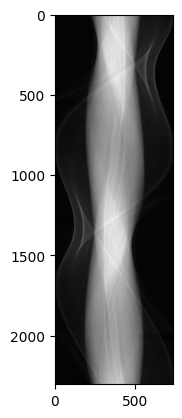

In [6]:
projections, metadata = load_tiff_stack_with_metadata("../helix2fan/out/scan_001_flat_fan_projections.tif")
# data = np.copy(np.flip(data, axis=1))
sino = np.copy(np.flip(projections[:, :, 15], axis=1)).astype(np.float64)

nnp = metadata['rotview']
lsd = metadata['dsd']
lso = metadata['dso']
nu = sino.shape[1]
du = metadata['dv_rebinned']
# dx = dy = 1
hu_factor = metadata['hu_factor']
angles = np.array(metadata['angles'])[:metadata['rotview']] + (np.pi / 2)

testID = 'LDCT_L170_test'

print(nnp, nu, du, lsd, lso, hu_factor)
print(metadata.keys())
print(metadata['det_central_element'])

plt.imshow(sino, cmap='gray')

A_B0 = A_B0_operator(nx, ny, nnp, nu, dx, dy, du, lsd, lso, angles)
A_B1 = A_B1_operator(nx, ny, nnp, nu, dx, dy, du, lsd, lso, angles)

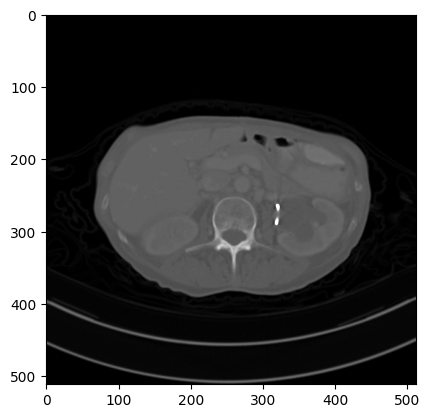

In [3]:
from pydicom import dcmread

_ds = dcmread("../data/L170/12-23-2021-NA-NA-52303/1.000000-Full Dose Images-14260/1-040.dcm")
_intercept = np.float64(_ds.RescaleIntercept)
_slope = np.float64(_ds.RescaleSlope)
# print(_ds)
x_ref = _ds.pixel_array.astype(np.float64) * _slope + _intercept

mmax = 2000 
mmin = -1000

dmax = 200
dmin = 0

nx = _ds.Rows
ny = _ds.Columns
dx, dy = _ds.PixelSpacing

plt.imshow(x_ref, cmap='gray', vmax = mmax, vmin = mmin)

In [118]:
A_B0 = A_B0_operator(nx, ny, nnp, nu, dx, dy, du, lsd, lso, angles)
A_B1 = A_B1_operator(nx, ny, nnp, nu, dx, dy, du, lsd, lso, angles)
# A_B0_matrix = A_B0_operator_matrix(nx, ny, nnp, nu, dx, dy, du, lsd, lso)
# A_B1 = A_B1_operator_matrix(nx, ny, nnp, nu, dx, dy, du, lsd, lso)
# A_Hl = A_Hl_operator_matrix(nl, nc, nnp, nu, dt, du, lsd, lso)
# A_H0 = A_H0_operator_matrix(H0_nl, H0_nc, nnp, nu, dt, du, lsd, lso)

16 32 16 8


75.46681497370965


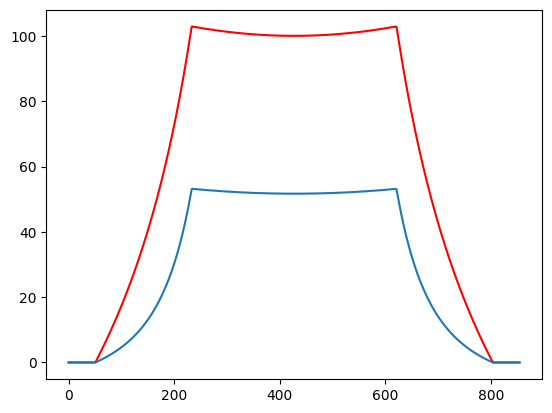

In [ ]:
x = np.ones((nx, ny), dtype=np.float64)

y0 = A_B0.matvec(x.ravel()).reshape((nnp, nu))
y1 = A_B1.matvec(x.ravel()).reshape((nnp, nu))
y2 = A_SF.matvec(x.ravel()).reshape((nnp, nu))

# r_test0 = A_B0.rmatvec(sino.ravel()).reshape(nx, ny)
# r_test1 = A_B1.rmatvec(sino.ravel()).reshape(nx, ny)
r_test2 = A_SF.rmatvec(sino.ravel()).reshape(nx, ny)
# r_test0 = (r_test0-hu_factor)/hu_factor*1000
# r_test1 = (r_test1-hu_factor)/hu_factor*1000
print(np.max(y2))
# plt.imshow(y2, cmap='gray')

plt.plot(np.arange(nu), y0[0], color='r')
plt.plot(np.arange(nu), y2[0])

# Reconstuction

In [6]:
# img_sample_180_855 = backward_from_projection(sino_180_855, ref_mat)

x_B0_ref, istop, itn, normr = lsmr(A_B0_ref_sparse, sino_180_855.ravel(), atol=1e-8, btol=1e-8)[:4]

print(istop, itn, normr)

x_B0_ref = x_B0_ref.reshape(nx, ny)

print(np.max(x_B0_ref), np.min(x_B0_ref), np.mean(x_B0_ref))

plt.imshow(x_B0_ref, cmap='gray', vmax = 0.2, vmin = 0)

NameError: name 'A_B0_ref_sparse' is not defined

3.0830298937812075 -0.20598156036948975 0.6362122220593939


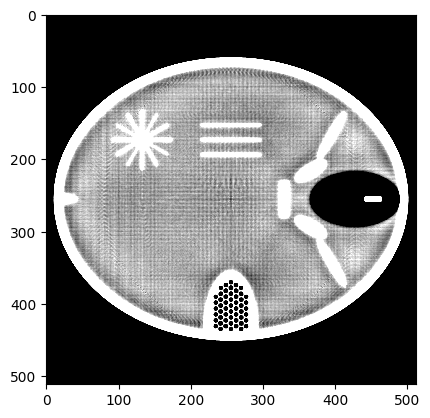

In [31]:
x_SF, istop, itn, normr = pylops.optimization.leastsquares.regularized_inversion(
    A_SF, sino.ravel(), [], engine='pylops', **dict(tol=1e-8, niter=10, itershow=(1000, 100, 1))
)[:4]

# x_B0, istop, itn, normr = pylops.optimization.leastsquares.regularized_inversion(
#     A_B0, sino_720_855.ravel(), [], **dict(show=True)
# )[:4]

# Dop = [
#     pylops.FirstDerivative(
#         (nx, ny), axis=0, edge=True, kind="backward", dtype=np.float64
#     ),
#     pylops.FirstDerivative(
#         (nx, ny), axis=1, edge=True, kind="backward", dtype=np.float64
#     ),
# ]

# x_B0 = pylops.optimization.sparsity.splitbregman(A_B0, sino_180_855.ravel(), Dop, tol=1e-8, epsRL1s = [0.2, 0.2], show=True)[0]

x_SF = x_SF.reshape(nx, ny)
if 'hu_factor' in globals():
    x_SF = (x_SF-hu_factor)/hu_factor*1000
    x_SF = np.flipud(np.fliplr(x_SF))

print(np.max(x_SF/6), np.min(x_SF/6), np.mean(x_SF/6))

plt.imshow(x_SF/6, cmap='gray', vmax=mmax, vmin=mmin)
plt.imsave("./eval_results/eval_x_SF_" + testID + ".png", x_SF/6, cmap='gray', vmax = mmax, vmin = mmin)

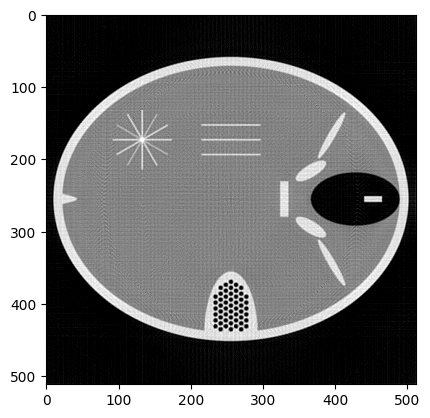

In [11]:
plt.imshow(x_SF/6, cmap='gray', vmax=2, vmin=0)
plt.imsave("./eval_results/eval_x_SF_" + testID + ".png", x_SF, cmap='gray', vmax = mmax, vmin = mmin)

4.739851805235447 -0.25960934244514094 0.6444974353208667


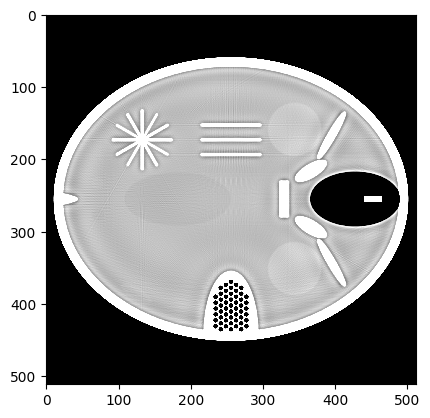

In [33]:
x_B0, istop, itn, normr = pylops.optimization.leastsquares.regularized_inversion(
    A_B0, sino.ravel(), [], engine='pylops', **dict(tol=1e-8, niter=20, itershow=(1000, 100, 1))
)[:4]

# x_B0, istop, itn, normr = pylops.optimization.leastsquares.regularized_inversion(
#     A_B0, sino_720_855.ravel(), [], **dict(show=True)
# )[:4]

# Dop = [
#     pylops.FirstDerivative(
#         (nx, ny), axis=0, edge=True, kind="backward", dtype=np.float64
#     ),
#     pylops.FirstDerivative(
#         (nx, ny), axis=1, edge=True, kind="backward", dtype=np.float64
#     ),
# ]

# x_B0 = pylops.optimization.sparsity.splitbregman(A_B0, sino_180_855.ravel(), Dop, tol=1e-8, epsRL1s = [0.2, 0.2], show=True)[0]

x_B0 = x_B0.reshape(nx, ny)
if 'hu_factor' in globals():
    x_B0 = (x_B0-hu_factor)/hu_factor*1000
    x_B0 = np.flipud(np.fliplr(x_B0))

print(np.max(x_B0), np.min(x_B0), np.mean(x_B0))

plt.imshow(x_B0, cmap='gray', vmax=mmax, vmin=mmin)
plt.imsave("./eval_results/eval_x_B0_" + testID + ".png", x_B0, cmap='gray', vmax = mmax, vmin = mmin)

4.867448884922616 -0.2972974183638659 0.6443872057527696


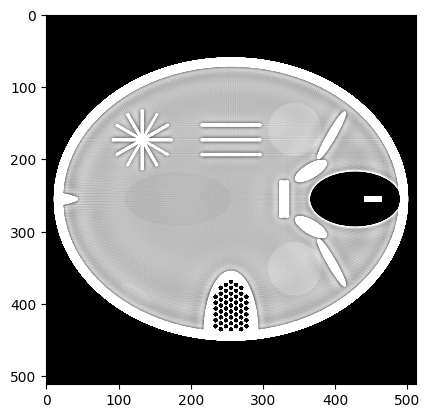

In [34]:
x_B1, istop, itn, normr = pylops.optimization.leastsquares.regularized_inversion(
    A_B1, sino.ravel(), [], engine='pylops', **dict(tol=1e-8, niter=22, itershow=(1000, 100, 1))
)[:4]

# x_B1, istop, itn, normr = pylops.optimization.leastsquares.regularized_inversion(
#     A_B1, sino.ravel(), [], **dict(show=True)
# )[:4]

# Dop = [
#     pylops.FirstDerivative(
#         (nx, ny), axis=0, edge=True, kind="backward", dtype=np.float64
#     ),
#     pylops.FirstDerivative(
#         (nx, ny), axis=1, edge=True, kind="backward", dtype=np.float64
#     ),
# ]

# x_B1 = pylops.optimization.sparsity.splitbregman(A_B1, sino.ravel(), Dop, niter_outer=4, tol=1e-8, epsRL1s = [2.0, 2.0], show=True)[0]

x_B1 = x_B1.reshape(nx, ny)
if 'hu_factor' in globals():
    x_B1 = (x_B1-hu_factor)/hu_factor*1000
    x_B1 = np.flipud(np.fliplr(x_B1))

print(np.max(x_B1), np.min(x_B1), np.mean(x_B1))

plt.imshow(x_B1, cmap='gray', vmax=mmax, vmin=mmin)
plt.imsave("./eval_results/eval_x_B1_" + testID + ".png", x_B1, cmap='gray', vmax = mmax, vmin = mmin)

66544.18595901782
43704.10791141809
[ -993.  -999.  -996. -1001.  -992.  -983. -1007. -1020. -1011. -1011. -1010.  -998. -1000. -1015. -1022. -1017. -1016. -1022. -1012. -1004.  -984.  -990.  -995. -1002. -1009. -1004.  -990. -1003.  -997.  -981.  -996. -1005. -1012. -1013. -1018.  -992.  -970.  -984.  -988.  -976.  -983. -1007. -1003. -1007. -1014. -1012.  -987.  -995. -1009. -1008.  -993.  -979.  -989.  -999. -1004.  -986.  -949.  -975. -1014. -1003.  -861.  -439.   -76.   -31.   -20.   -19.   -18.   -34.
   -29.   -41.   -27.   -35.   -33.   -42.   -51.    -2.    -6.   -27.    27.   -21.   -26.    14.    22.    41.     5.    13.    23.    -2.    15.    39.    39.    30.    10.    -3.    26.    36.     6.     3.   -27.   -12.    33.    19.     0.   -10.    10.   -10.   -46.    -5.    23.    -4.    13.    32.    -5.   -20.   -14.     8.    17.    -6.     5.    22.     6.    26.    28.    47.     4.    13.    14.     7.   -20.   -18.    43.    28.   -35.    -8.     4.    11.
    28.   

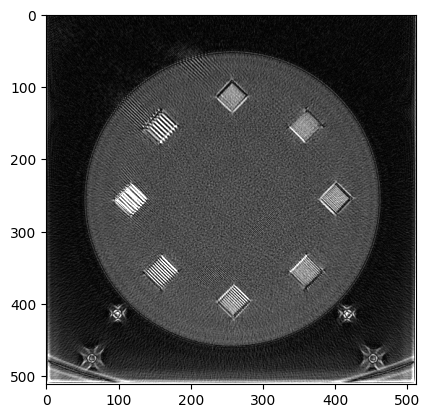

In [33]:
plt.imshow(abs(x_B1-x_ref), cmap='gray', vmax=1000, vmin=0)
# plt.imsave("./eval_results/diff_ACR_B0_B1.png", abs(x_B1-x_B0), cmap='gray', vmax=100, vmin=0)

print(np.mean(x_B0-x_ref)**2)
print(np.mean(x_B1-x_ref)**2)
print(x_ref[200])
print(x_B1[200])


In [6]:
# hex_mat = hex_mat_presolve(hex_mat)
# hex_img = backward_from_projection_hex(sino_180_855, hex_mat)

x_Hl, istop, itn, normr = lsmr(A_Hl_sparse, sino_360_1710.ravel(), atol=1e-8, btol=1e-8)[:4]

print(istop, itn, normr)

x_Hl = x_Hl.reshape(nl, nc) * 10 / (dt*dt*1.5/np.sqrt(3))

print(np.max(x_Hl), np.min(x_Hl), np.mean(x_Hl))

plt.imshow(x_Hl, cmap='gray', vmax = 2, vmin = 0)

2 268 12.132780260917562
0.03912991662033903 -0.013615741653542691 0.009853103049312188


2 187 14.821548331369971
2.3566041907594886 -0.4120028450328983 0.6287565362786377


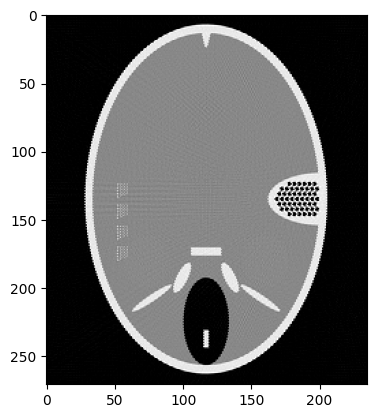

In [22]:
x_H0, istop, itn, normr = lsmr(A_H0_sparse, sino_360_1710.ravel(), atol=1e-8, btol=1e-8)[:4]

print(istop, itn, normr)

x_H0 = x_H0[:H0_nl*H0_nc].reshape(H0_nl, H0_nc) * 10 / (dt*dt*1.5/np.sqrt(3))

print(np.max(x_H0), np.min(x_H0), np.mean(x_H0))

plt.imshow(x_H0, cmap='gray', vmax = 2, vmin = 0)

# Evaluation

### Baseline

In [3]:
eval_points = 3000

0.6484057988888887 5.85


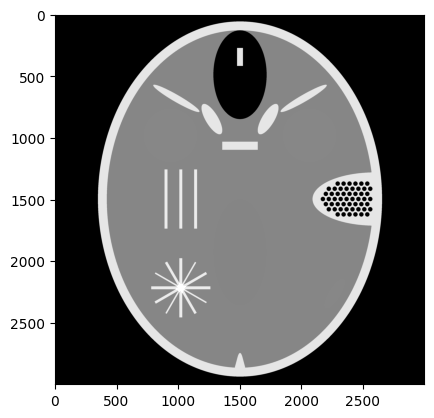

In [4]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
base = discrete_phantom(xcoords, ycoords)
base = base.reshape((eval_points, eval_points))

print(np.mean(base), np.max(base))

plt.imshow(base, cmap='gray', vmin = 0, vmax = 2)

In [5]:
def pixel_value(x, y, pmap):
    eps = 1e-10

    x1 = x + (nx / 2) * dx
    y1 = y + (ny / 2) * dy

    x1 = np.floor(x1/dx).astype(int)
    y1 = np.floor(y1/dy).astype(int)

    return pmap[x1, y1]

def interpolate_ref(x, y, pmap):
    x0 = x + (nx / 2) * dx
    y0 = y + (ny / 2) * dy

    x0 = x0 / dx + 0.5
    y0 = y0 / dy + 0.5

    pmap = np.pad(pmap, pad_width=1, mode='edge')

    x1 = np.floor(x0).astype(int)
    x2 = x1+1
    y1 = np.floor(y0).astype(int)
    y2 = y1+1
    
    return pmap[x1, y1] * (x2-x0) * (y2-y0) + pmap[x1, y2] * (x2-x0) * (y0-y1) + pmap[x2, y1] * (x0-x1) * (y2-y0) + pmap[x2, y2] * (x0-x1) * (y0-y1)

def bilinear_value_pixel(x, y, pmap):
    x0 = x + (nx / 2) * dx
    y0 = y + (ny / 2) * dy

    x0 = x0 / dx + 0.5
    y0 = y0 / dy + 0.5

    pmap = np.pad(pmap, pad_width=1, mode='edge')

    x1 = np.floor(x0).astype(int)
    x2 = x1+1
    y1 = np.floor(y0).astype(int)
    y2 = y1+1


    return pmap[x1, y1] * (x2-x0) * (y2-y0) + pmap[x1, y2] * (x2-x0) * (y0-y1) + pmap[x2, y1] * (x0-x1) * (y2-y0) + pmap[x2, y2] * (x0-x1) * (y0-y1)

def FWHM_evaluate(pmap, start, end, contrast):
    contrast /= 2

    left = []
    right = []
    if start[0] == end[0]:
        x = start[0]
        for y in range(start[1], end[1]):
            if pmap[x, y] < 1.0 + contrast and pmap[x, y+1] > 1.0 + contrast:
                diff = np.fabs(pmap[x, y+1] - pmap[x, y])
                spoint = (1.0 + contrast - pmap[x, y])/diff + y
                spoint *= dx 
                left.append(spoint)
            if pmap[x, y] > 1.0 + contrast and pmap[x, y+1] < 1.0 + contrast:
                diff = np.fabs(pmap[x, y+1] - pmap[x, y])
                spoint = y + 1 - (1.0 + contrast - pmap[x, y+1])/diff
                spoint *= dx 
                right.append(spoint)
    else:
        y = start[1]
        for x in range(start[0], end[0]):
            if pmap[x, y] < 1.0 + contrast and pmap[x+1, y] > 1.0 + contrast:
                diff = np.fabs(pmap[x, y] - pmap[x+1, y])
                spoint = (1.0 + contrast - pmap[x, y])/diff + x
                spoint *= dx 
                left.append(spoint)
            if pmap[x, y] > 1.0 + contrast and pmap[x+1, y] < 1.0 + contrast:
                diff = np.fabs(pmap[x, y] - pmap[x+1, y])
                spoint = x+1 - (1.0 + contrast - pmap[x+1, y])/diff
                spoint *= dx
                right.append(spoint)
    
    return left, right

### Models

In [7]:
iters = np.arange(2, 65, 2)
# iters = [19]
PSNRs_B0 = []
RMSEs_B0 = []
SSIMs_B0 = []
FWHMs_B0 = []

for epoch in iters:
    x_B0 = pylops.optimization.leastsquares.regularized_inversion(
        A_B0, sino.ravel(), [], engine='pylops', **dict(tol=1e-8, niter=epoch))[0]

    x, step = np.linspace(-nx*dx/2, nx*dx/2, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
    x += step / 2

    xcoords, ycoords = np.meshgrid(x, np.flip(x))
    eval_B0 = pixel_value(xcoords, ycoords, x_B0.reshape(nx, ny)).reshape((eval_points, eval_points))
    eval_B01 = bilinear_value_pixel(xcoords, ycoords, x_B0.reshape(nx, ny)).reshape((eval_points, eval_points))
    sumFWHM = []
    for sampley in range(int(ny/2)-int(ny/15), int(ny/2)+int(ny/15)):
        Fleft, Fright = FWHM_evaluate(x_B0.reshape(nx, ny), (nx>>2, sampley), (nx>>1, sampley), 0.8)
        if len(Fleft) == 3 and len(Fright) == 3:
            sumFWHM.append(Fright[0] - Fleft[0])

    FWHM = np.mean(sumFWHM) / 0.4
    SSIM, ssim_B0 = ssim(eval_B0, base, full=True, data_range = 2.0)
    SSIM1, ssim_B01 = ssim(eval_B01, base, full=True, data_range = 2.0)
    PSNR = psnr(eval_B0, base, data_range = 2.0)
    PSNR1 = psnr(eval_B01, base, data_range = 2.0)

    diff_B0 = np.fabs(eval_B0-base)
    diff_B01 = np.fabs(eval_B01-base)

    if 'epoch' not in globals():
        epoch = -1
    print(epoch, '\tPSNR:', PSNR, '\tRMSE:', np.mean(diff_B0**2), '\tFWHM:', FWHM, '\tSSIM:', SSIM)
    print('\tPSNR:', PSNR1, '\tRMSE:', np.mean(diff_B01**2), '\tSSIM:', SSIM1)
    PSNRs_B0.append(PSNR)
    RMSEs_B0.append(np.mean(diff_B0**2))
    SSIMs_B0.append(SSIM)
    FWHMs_B0.append(FWHM)

    # f, axarr = plt.subplots(1,2,figsize=(20, 10))
    # axarr[0].imshow(eval_B0, cmap='gray', vmin = mmin, vmax = mmax)
    # axarr[1].imshow(diff_B0, cmap='gray', vmin = dmin, vmax = dmax)
    # plt.imsave("./eval_results/eval_x_B0_" + testID + ".png", eval_B0, cmap='gray', vmin = mmin, vmax = mmax)
    # plt.imsave("./eval_results/diff_x_B0_" + testID + ".png", diff_B0, cmap='gray', vmin = dmin, vmax = dmax)

# f, axarr = plt.subplots(1,1,figsize=(8, 5))
# axarr.plot(iters, np.array(RMSEs_B0)*100, color='r')
# axarr.plot(iters, FWHMs_B0, color='b')
# axarr.plot(iters, SSIMs_B0, color='y')

/home/ke/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ke/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2 	PSNR: 15.210201850000406 	RMSE: 0.12051463959639842 	FWHM: nan 	SSIM: 0.580568346879554
	PSNR: 15.207981430075758 	RMSE: 0.12057627094011249 	SSIM: 0.5812238869732879
4 	PSNR: 18.239239163329874 	RMSE: 0.05999790347920546 	FWHM: nan 	SSIM: 0.6418163744502264
	PSNR: 18.229508461666235 	RMSE: 0.06013248410617752 	SSIM: 0.6446348622418127
6 	PSNR: 21.34294213336149 	RMSE: 0.029360657573431745 	FWHM: nan 	SSIM: 0.726742848094834
	PSNR: 21.323184271727374 	RMSE: 0.02949453571467538 	SSIM: 0.73326690152234
8 	PSNR: 22.91529946838425 	RMSE: 0.020442313510228363 	FWHM: 0.30037100460190164 	SSIM: 0.7793298054931096
	PSNR: 22.9033246055889 	RMSE: 0.02049875716930042 	SSIM: 0.7874495570129603
10 	PSNR: 24.099450508391172 	RMSE: 0.015563774883664219 	FWHM: 0.9300327805052178 	SSIM: 0.8150867321305472
	PSNR: 24.125977539766687 	RMSE: 0.015468999924973905 	SSIM: 0.8243792340597993
12 	PSNR: 24.962385136605718 	RMSE: 0.012759142200485052 	FWHM: 1.216479174124548 	SSIM: 0.8358588433366015
	PSNR: 25

In [8]:
# iters = np.arange(2, 65, 2)
# # iters = [22]
PSNRs_B1 = []
RMSEs_B1 = []
SSIMs_B1 = []
FWHMs_B1 = []

for epoch in iters:
    x_B1 = pylops.optimization.leastsquares.regularized_inversion(
        A_B1, sino.ravel(), [], engine='pylops', **dict(tol=1e-8, niter=epoch))[0]

    x, step = np.linspace(-nx*dx/2, nx*dx/2, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
    x += step / 2

    xcoords, ycoords = np.meshgrid(x, np.flip(x))
    eval_B1 = bilinear_value_pixel(xcoords, ycoords, x_B1.reshape(nx, ny)).reshape((eval_points, eval_points))

    sumFWHM = []
    for sampley in range(int(ny/2)-int(ny/15), int(ny/2)+int(ny/15)):
        Fleft, Fright = FWHM_evaluate(x_B1.reshape(nx, ny), (nx>>2, sampley), (nx>>1, sampley), 0.8)
        if len(Fleft) == 3 and len(Fright) == 3:
            sumFWHM.append(Fright[0] - Fleft[0])
            sumFWHM.append(Fright[1] - Fleft[1])
            sumFWHM.append(Fright[2] - Fleft[2])

    FWHM = np.mean(sumFWHM) / 0.4
    SSIM, ssim_B1 = ssim(eval_B1, base, full=True, data_range = 2.0)
    PSNR = psnr(eval_B1, base, data_range = 2.0)

    diff_B1 = np.fabs(eval_B1-base)

    if 'epoch' not in globals():
        epoch = -1
    print(epoch, '\tPSNR:', PSNR, '\tRMSE:', np.mean(diff_B1**2), '\tFWHM:', FWHM, '\tSSIM:', SSIM)
    PSNRs_B1.append(PSNR)
    RMSEs_B1.append(np.mean(diff_B1**2))
    SSIMs_B1.append(SSIM)
    FWHMs_B1.append(FWHM)
    

    # mmin = 0.9
    # mmax = 1.1
    # f, axarr = plt.subplots(1,2,figsize=(20, 10))
    # axarr[0].imshow(eval_B1, cmap='gray', vmin = mmin, vmax = mmax)
    # # axarr[1].imshow(diff_B1, cmap='gray', vmin = dmin, vmax = dmax)
    # axarr[1].imshow(ssim_B1, cmap='gray')
    # plt.imsave("./eval_results/eval_x_B1_" + testID + ".png", eval_B1, cmap='gray', vmin = mmin, vmax = mmax)
    # plt.imsave("./eval_results/diff_x_B1_" + testID + ".png", diff_B1, cmap='gray', vmin = dmin, vmax = dmax)
    # plt.imsave("./eval_results/ssim_x_B1_" + testID + ".png", ssim_B1, cmap='gray')

# f, axarr = plt.subplots(1,1,figsize=(8, 5))
# axarr.plot(iters, np.array(PSNRs_B1)/30, color='r')
# axarr.plot(iters, FWHMs_B1, color='b')
# axarr.plot(iters, SSIMs_B1, color='y')

2 	PSNR: 15.205874857694756 	RMSE: 0.12063477139671393 	FWHM: nan 	SSIM: 0.581178700792648
4 	PSNR: 18.218954290640617 	RMSE: 0.06027879503816175 	FWHM: nan 	SSIM: 0.644446520514299
6 	PSNR: 21.289508000354477 	RMSE: 0.029724132686075242 	FWHM: nan 	SSIM: 0.7329300954903945
8 	PSNR: 22.847165489029496 	RMSE: 0.020765550192546313 	FWHM: 0.21218737003057037 	SSIM: 0.7869885127048822
10 	PSNR: 24.048072144786182 	RMSE: 0.01574899252437012 	FWHM: 0.8933474259241703 	SSIM: 0.8239086277549239
12 	PSNR: 24.779067176141037 	RMSE: 0.013309240524944355 	FWHM: 1.1486114498722861 	SSIM: 0.8457171357990626
14 	PSNR: 25.595780942400047 	RMSE: 0.011027622659056586 	FWHM: 1.2426179019665038 	SSIM: 0.8563919826855938
16 	PSNR: 26.365183820764372 	RMSE: 0.009237226849812336 	FWHM: 1.2868049924083214 	SSIM: 0.8684283675352051
18 	PSNR: 26.725709925701302 	RMSE: 0.008501371578385052 	FWHM: 1.280310854434065 	SSIM: 0.8764288011530316
20 	PSNR: 26.853279944418055 	RMSE: 0.008255283588296924 	FWHM: 1.2639136

In [37]:
# iters = np.arange(2, 65, 2)
# PSNRs_SF = []
# RMSEs_SF = []
# SSIMs_SF = []
# FWHMs_SF = []

# for epoch in iters:
#     x_SF = pylops.optimization.leastsquares.regularized_inversion(
#         A_SF, sino.ravel(), [], engine='pylops', **dict(tol=1e-8, niter=epoch))[0]

x, step = np.linspace(-nx*dx/2, nx*dx/2, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_SF = pixel_value(xcoords, ycoords, x_SF.reshape(nx, ny)/6).reshape((eval_points, eval_points))
eval_SF1 = bilinear_value_pixel(xcoords, ycoords, x_SF.reshape(nx, ny)/6).reshape((eval_points, eval_points))
sumFWHM = []
for sampley in range(int(ny/2)-int(ny/15), int(ny/2)+int(ny/15)):
    Fleft, Fright = FWHM_evaluate(x_SF.reshape(nx, ny)/6, (nx>>2, sampley), (nx>>1, sampley), 0.8)
    if len(Fleft) == 3 and len(Fright) == 3:
        sumFWHM.append(Fright[0] - Fleft[0])

FWHM = np.mean(sumFWHM) / 0.4
SSIM, ssim_SF = ssim(eval_SF, base, full=True, data_range = 2.0)
SSIM1, ssim_SF1 = ssim(eval_SF1, base, full=True, data_range = 2.0)
PSNR = psnr(eval_SF, base, data_range = 2.0)
PSNR1 = psnr(eval_SF1, base, data_range = 2.0)

diff_SF = np.fabs(eval_SF-base)
diff_SF1 = np.fabs(eval_SF1-base)

if 'epoch' not in globals():
    epoch = -1
print(epoch, '\tPSNR:', PSNR, '\tRMSE:', np.mean(diff_SF**2), '\tFWHM:', FWHM, '\tSSIM:', SSIM)
print('\tPSNR:', PSNR1, '\tRMSE:', np.mean(diff_SF1**2), '\tSSIM:', SSIM1)
PSNRs_SF.append(PSNR)
RMSEs_SF.append(np.mean(diff_SF**2))
SSIMs_SF.append(SSIM)
FWHMs_SF.append(FWHM)

20 	PSNR: 23.573533654100935 	RMSE: 0.017567365045317702 	FWHM: 0.5974565033818174 	SSIM: 0.6885852471439391
	PSNR: 23.64304955587349 	RMSE: 0.017288409295998657 	SSIM: 0.7218674740158727


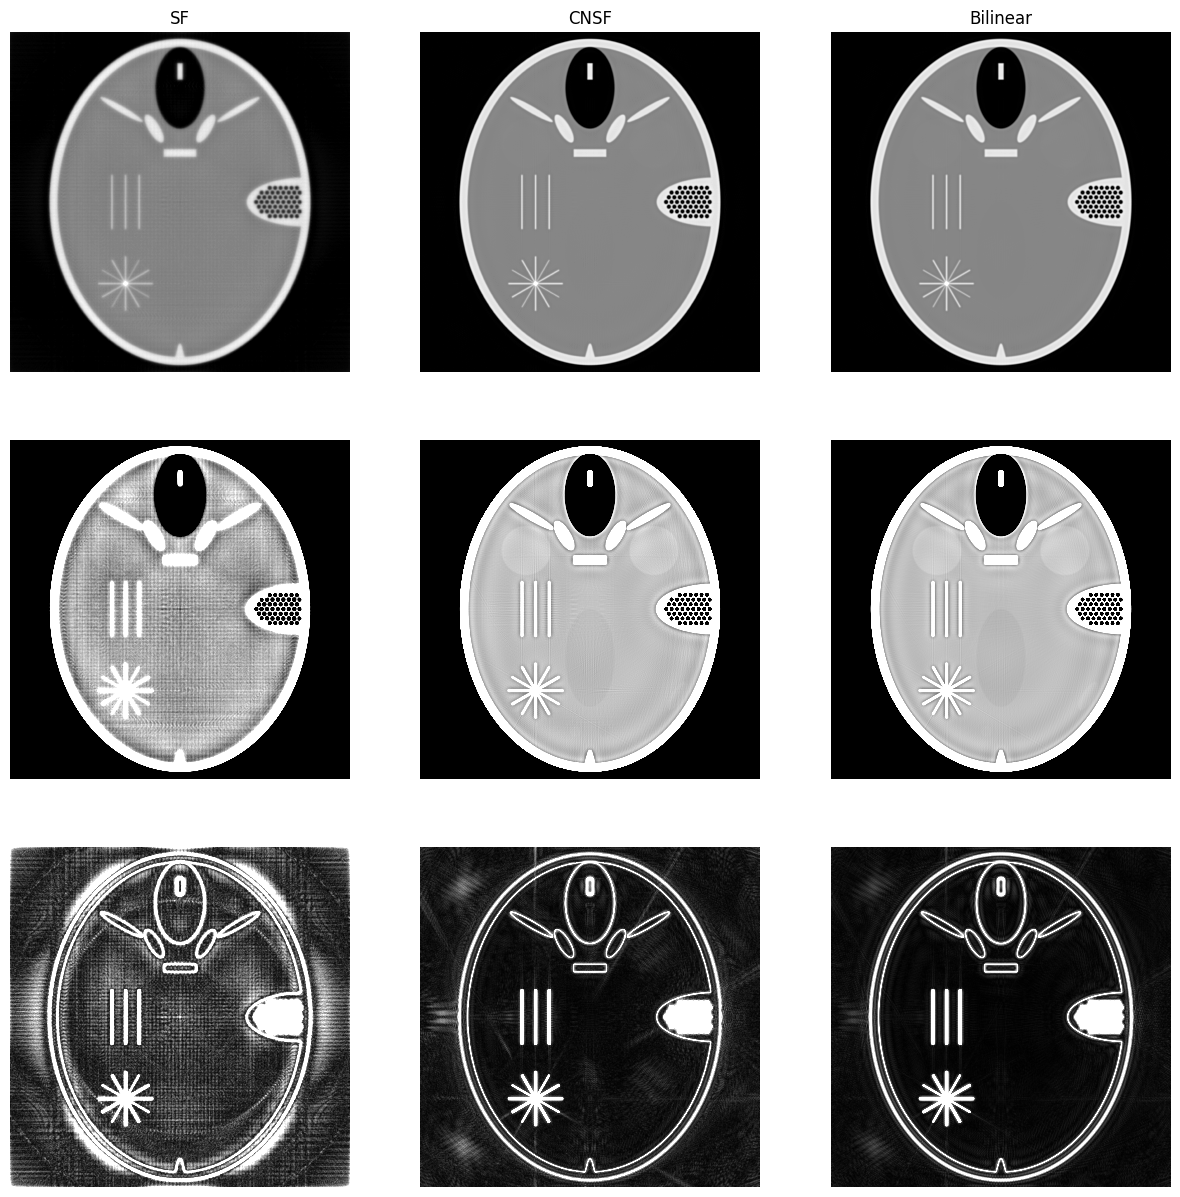

In [45]:
f, axarr = plt.subplots(3,3,figsize=(15, 15))

for i in range(0, 3):
    for j in range(0, 3):
        axarr[i, j]. axis('off')

axarr[0, 0].set_title("SF")
axarr[0, 1].set_title("CNSF")
axarr[0, 2].set_title("Bilinear")

axarr[0, 0].imshow(eval_SF, cmap='gray', vmax = 2.0, vmin = 0.0)
axarr[0, 1].imshow(eval_B0, cmap='gray', vmax = 2.0, vmin = 0.0)
axarr[0, 2].imshow(eval_B1, cmap='gray', vmax = 2.0, vmin = 0.0)

axarr[1, 0].imshow(eval_SF, cmap='gray', vmax = 1.1, vmin = 0.9)
axarr[1, 1].imshow(eval_B0, cmap='gray', vmax = 1.1, vmin = 0.9)
axarr[1, 2].imshow(eval_B1, cmap='gray', vmax = 1.1, vmin = 0.9)

axarr[2, 0].imshow(np.fabs(diff_SF), cmap='gray', vmax = 0.1, vmin = 0)
axarr[2, 1].imshow(np.fabs(diff_B0), cmap='gray', vmax = 0.1, vmin = 0)
axarr[2, 2].imshow(np.fabs(diff_B1), cmap='gray', vmax = 0.1, vmin = 0)

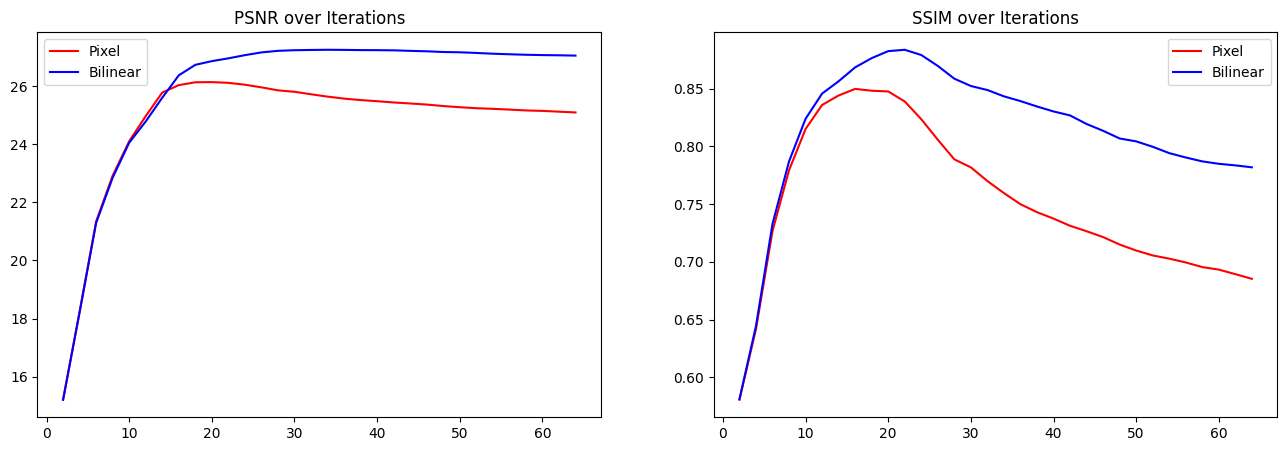

In [9]:
f, axarr = plt.subplots(1,2,figsize=(16, 5))

axarr[0].plot(iters, PSNRs_B0, color='r', label='Pixel')
axarr[0].plot(iters, PSNRs_B1, color='b', label='Bilinear')
axarr[0].set_title("PSNR over Iterations")
axarr[0].legend()

axarr[1].plot(iters, SSIMs_B0, color='r', label='Pixel')
axarr[1].plot(iters, SSIMs_B1, color='b', label='Bilinear')
axarr[1].set_title("SSIM over Iterations")
axarr[1].legend()

In [ ]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_ref = pixel_value(xcoords, ycoords, x_B0_ref).reshape((eval_points, eval_points))
# inte_ref = interpolate_ref(xcoords, ycoords, x_B0_ref).reshape((eval_points, eval_points))

diff_ref = np.fabs(eval_ref-base)
# diff_inte = np.fabs(inte_ref-base)

print(np.max(diff_ref))
print(np.mean(diff_ref**2))
# print(np.max(diff_inte))
# print(np.mean(diff_inte**2))

plt.imsave("./eval_results/eval_x_B0_ref.png", eval_ref, cmap='gray', vmin = 0, vmax = 2)
plt.imsave("./eval_results/diff_x_B0_ref.png", diff_ref, cmap='gray', vmin = 0, vmax = 0.4)
# plt.imsave("./eval_results/diff_x_B0_ref_inte.png", diff_inte, cmap='gray', vmin = 0, vmax = 0.4)

In [27]:
h_dy = dt / 2
h_dx = dt * np.sqrt(3)

def l2y(l):
    return (l - (nl - 1) / 2) * h_dy

def c2x_outer(c):
    return (c - (nc - 1) / 2) * h_dx

def c2x_inner(c):
    return (c - (nc - 2) / 2) * h_dx

def x2c_outer(x):
    return x / h_dx + (nc-1)/2

def x2c_inner(x):
    return x / h_dx + (nc-2)/2

def distsq(x, y, hx, hy):
    return (x - hx) ** 2 + (y - hy) ** 2

def abscross(x1, y1, x2, y2):
    return np.fabs(x1*y2 - x2*y1)

def p_area(p1, p2, p3):
    return abscross(p1[0]-p2[0], p1[1]-p2[1], p1[0]-p3[0], p1[1]-p3[1])

def hex_value_evaluate(x, y, mat):
    target = np.array([x, y])
    val = 0

    l = y / h_dy + (nl - 1) / 2

    lf = np.floor(l).astype(int)
    lc = lf + 1

    c = x2c_outer(x)
    cinner = x2c_inner(x)

    cf = np.floor(c).astype(int)
    cc = cf + 1

    cif = np.floor(cinner).astype(int)
    cic = cif + 1

    outerf = np.bitwise_and(lc, 1).astype(bool)
    outerc = np.logical_not(outerf)

    l1 = l2 = lf
    l3 = l4 = lc

    c1 = cf * outerf + cif * outerc
    c2 = cc * outerf + cic * outerc
    c3 = cf * outerc + cif * outerf
    c4 = cc * outerc + cic * outerf

    hcenters = np.zeros((9, 3, x.shape[0], x.shape[1]), dtype = np.float64) # x, y, v
    tri = np.zeros((x.shape[0], x.shape[1], 3, 3), dtype = np.float64)

    hcenters[1, 0] = hcenters[5, 0] = c2x_outer(cf) * outerf + c2x_inner(cif) * outerc
    hcenters[2, 0] = hcenters[6, 0] = c2x_outer(cc) * outerf + c2x_inner(cic) * outerc
    hcenters[3, 0] = hcenters[7, 0] = c2x_outer(cf) * outerc + c2x_inner(cif) * outerf
    hcenters[4, 0] = hcenters[8, 0] = c2x_outer(cc) * outerc + c2x_inner(cic) * outerf

    hcenters[1, 1] = hcenters[2, 1] = l2y(lf)
    hcenters[5, 1] = hcenters[6, 1] = l2y(lf+2)
    hcenters[3, 1] = hcenters[4, 1] = l2y(lc)
    hcenters[7, 1] = hcenters[8, 1] = l2y(lc-2)

    hcenters[1, 2] = mat[l1, c1]
    hcenters[2, 2] = mat[l2, c2]
    hcenters[3, 2] = mat[l3, c3]
    hcenters[4, 2] = mat[l4, c4]
    hcenters[5, 2] = mat[l1+2, c1]
    hcenters[6, 2] = mat[l2+2, c2]
    hcenters[7, 2] = mat[l3-2, c3]
    hcenters[8, 2] = mat[l4-2, c4]

    rtilt = hcenters[3, 0] > hcenters[1, 0]

    cond1 = distsq(x, y, hcenters[7, 0], hcenters[7, 1]) < distsq(x, y, hcenters[6, 0], hcenters[6, 1])
    cond2 = distsq(x, y, hcenters[5, 0], hcenters[5, 1]) < distsq(x, y, hcenters[8, 0], hcenters[8, 1])

    t236 = (cond1 == False) & rtilt
    t237 = cond1 & rtilt
    t145 = cond2 & (rtilt == False)
    t148 = (cond2 == False) & (rtilt == False)

    hcenters = np.transpose(hcenters, (2, 3, 0, 1))

    # tmp = np.zeros(x.shape, dtype=str)
    # tmp[t236] = '#'
    # tmp[t237] = 'X'
    # tmp[t145] = '*'
    # tmp[t148] = 'O'
    # print(tmp)

    tri[t237] = hcenters[t237][:, [2,3,7]]
    tri[t236] = hcenters[t236][:, [2,3,6]]
    tri[t145] = hcenters[t145][:, [1,4,5]]
    tri[t148] = hcenters[t148][:, [1,4,8]]

    tri = np.transpose(tri, (2, 3, 0, 1))

    val += (tri[0, 2] * abscross(x-tri[1, 0], y-tri[1, 1], x-tri[2, 0], y-tri[2, 1]))
    val += (tri[1, 2] * abscross(x-tri[0, 0], y-tri[0, 1], x-tri[2, 0], y-tri[2, 1]))
    val += (tri[2, 2] * abscross(x-tri[0, 0], y-tri[0, 1], x-tri[1, 0], y-tri[1, 1]))

    sum = abscross(x-tri[1, 0], y-tri[1, 1], x-tri[2, 0], y-tri[2, 1]) + abscross(x-tri[0, 0], y-tri[0, 1], x-tri[2, 0], y-tri[2, 1]) + abscross(x-tri[0, 0], y-tri[0, 1], x-tri[1, 0], y-tri[1, 1])

    return val / (dt*dt*np.sqrt(3)/2)


In [11]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_hex = hex_value_evaluate(xcoords, ycoords, x_Hl)

diff_hex = np.fabs(base-eval_hex)

print(np.mean(eval_hex))
print(np.mean(diff_hex**2))

plt.imsave("./eval_results/eval_x_Hl.png", eval_hex, cmap='gray', vmin = 0, vmax = 2)
plt.imsave("./eval_results/diff_x_Hl.png", diff_hex, cmap='gray', vmin = 0, vmax = 0.4)

0.6411865620986805
0.008202593595471097


In [56]:
h0_dy = H0_dt * 3 / 2
h0_dx = H0_dt * np.sqrt(3)

def h0_value_evaluate(x, y, mat):
    res = np.zeros(x.shape, dtype=np.float64)

    l = y / h0_dy + (H0_nl - 1) / 2
    lf = np.floor(l).astype(int)
    yf = (lf - (H0_nl - 1) / 2) * h0_dy
    outerc = np.bitwise_and(lf, 1).astype(bool)
    outerf = np.logical_not(outerc)

    c = x / h0_dx + (H0_nc-1)/2
    cof = np.floor(c).astype(int)
    xof = (cof - (H0_nc - 1) / 2) * h0_dx

    p1 = np.logical_and ( outerf , ((y - yf) < 0.5 * H0_dt) )
    p2 = np.logical_and ( outerf , np.logical_and ((y - yf) >= 0.5 * H0_dt , (y - yf) < H0_dt) )
    p3 = np.logical_and ( outerf , ((y - yf) >= H0_dt) )

    p4 = np.logical_and ( outerc , ((y - yf) < 0.5 * H0_dt) )
    p5 = np.logical_and ( outerc , np.logical_and ((y - yf) >= 0.5 * H0_dt , (y - yf) < H0_dt) )
    p6 = np.logical_and ( outerc , ((y - yf) >= H0_dt) )

    q1 = (x - xof) < 0.5 * h0_dx
    q2 = np.logical_not(q1)

    dist1 = distsq(x, y, xof, yf)
    dist2 = distsq(x, y, xof+h0_dx, yf)
    dist3 = distsq(x, y, xof+h0_dx/2, yf+h0_dy)

    dist4 = distsq(x, y, xof+h0_dx/2, yf)
    dist5 = distsq(x, y, xof, yf+h0_dy)
    dist6 = distsq(x, y, xof+h0_dx, yf+h0_dy)

    r1 = np.where(dist1 < dist3, mat[lf, cof], mat[lf+1, cof])
    r2 = np.where(dist2 < dist3, mat[lf, cof+1], mat[lf+1, cof])
    r3 = np.where(dist4 < dist5, mat[lf, cof], mat[lf+1, cof])
    r4 = np.where(dist4 < dist6, mat[lf, cof], mat[lf+1, cof+1])

    res[p1&q1] = mat[lf[p1&q1], cof[p1&q1]]
    res[p1&q2] = mat[lf[p1&q2], cof[p1&q2] + 1]
    
    res[p2&q1] = r1[p2&q1]
    res[p2&q2] = r2[p2&q2]

    res[p3] = mat[lf[p3] + 1, cof[p3]]

    res[p4] = mat[lf[p4], cof[p4]]

    res[p5&q1] = r3[p5&q1]
    res[p5&q2] = r4[p5&q2]

    res[p6&q1] = mat[lf[p6&q1] + 1, cof[p6&q1]]
    res[p6&q2] = mat[lf[p6&q2] + 1, cof[p6&q2] + 1]

    ar1 = np.where(dist1 < dist3, "1", "3")
    ar2 = np.where(dist2 < dist3, "2", "3")
    ar3 = np.where(dist4 < dist5, "4", "5")
    ar4 = np.where(dist4 < dist6, "4", "6")

    # deb = np.zeros(x.shape, dtype=str)
    # deb[p1&q1] = 'L'
    # deb[p1&q2] = 'R'
    
    # deb[p2&q1] = ar1[p2&q1]
    # deb[p2&q2] = ar2[p2&q2]

    # deb[p3] = 'M'

    # deb[p4] = 'M'

    # deb[p5&q1] = ar3[p5&q1]
    # deb[p5&q2] = ar4[p5&q2]

    # deb[p6&q1] = 'L'
    # deb[p6&q2] = 'R'

    # print(yf)
    # print(xof)
    # print(deb)

    return res

In [59]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_hex = h0_value_evaluate(xcoords, ycoords, x_H0)

diff_hex = np.fabs(base-eval_hex)

print(np.mean(eval_hex))
print(np.mean(diff_hex**2))

plt.imsave("./eval_results/eval_x_H0.png", eval_hex, cmap='gray', vmin = 0, vmax = 2)
plt.imsave("./eval_results/diff_x_H0.png", diff_hex, cmap='gray', vmin = 0, vmax = 0.4)

0.6502116808365723
0.014897590092805654


# Evaluation_ACR

In [9]:
eval_points = 512

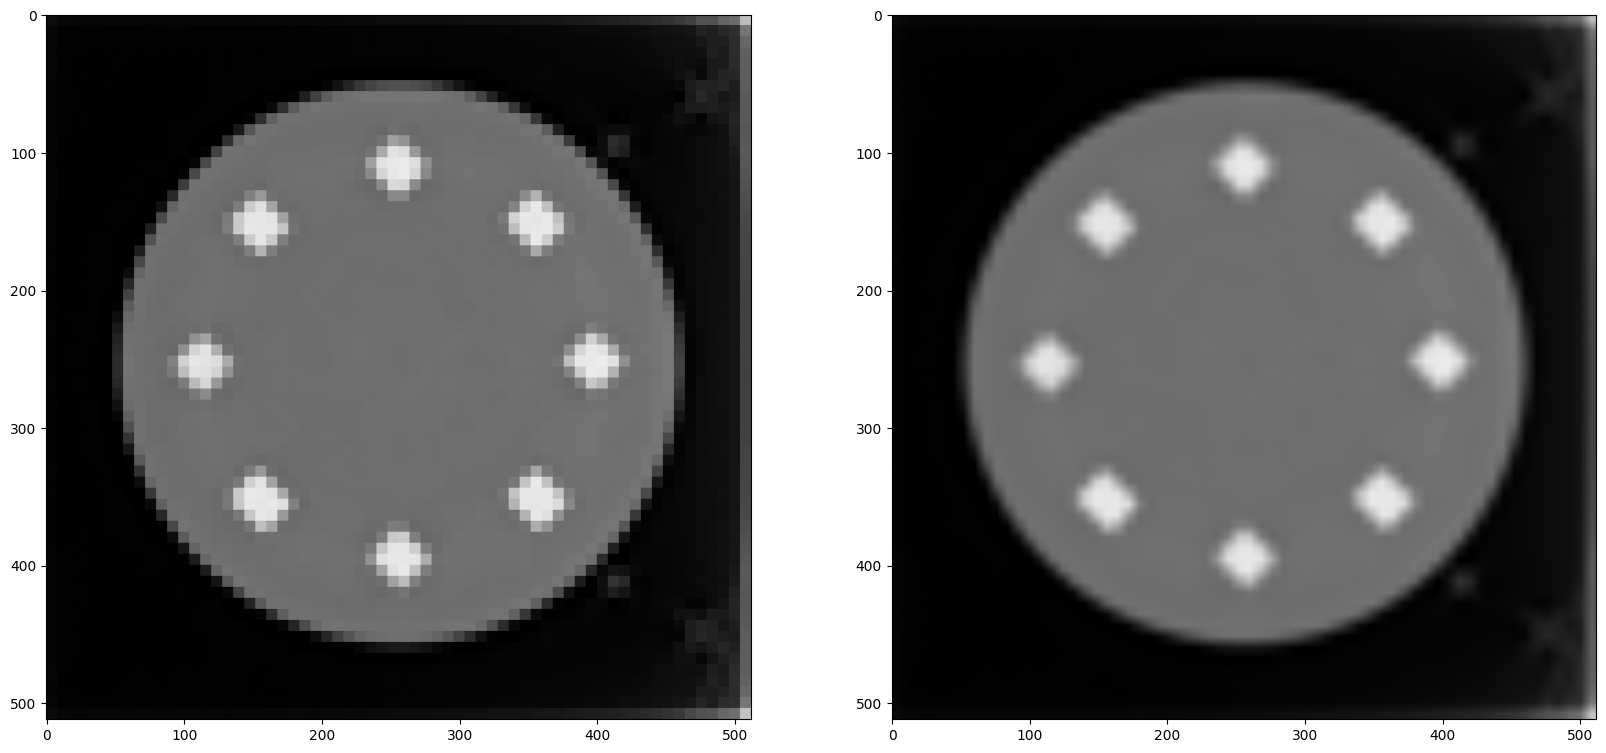

In [28]:
x, step = np.linspace(-nx*dx/2, nx*dx/2, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_B0 = pixel_value(xcoords, ycoords, x_B0.reshape(nx, ny)).reshape((eval_points, eval_points))
eval_B01 = bilinear_value_pixel(xcoords, ycoords, x_B0.reshape(nx, ny)).reshape((eval_points, eval_points))

f, axarr = plt.subplots(1,2,figsize=(20, 10))
axarr[0].imshow(eval_B0, cmap='gray', vmin = mmin, vmax = mmax)
axarr[1].imshow(eval_B01, cmap='gray', vmin = mmin, vmax = mmax)

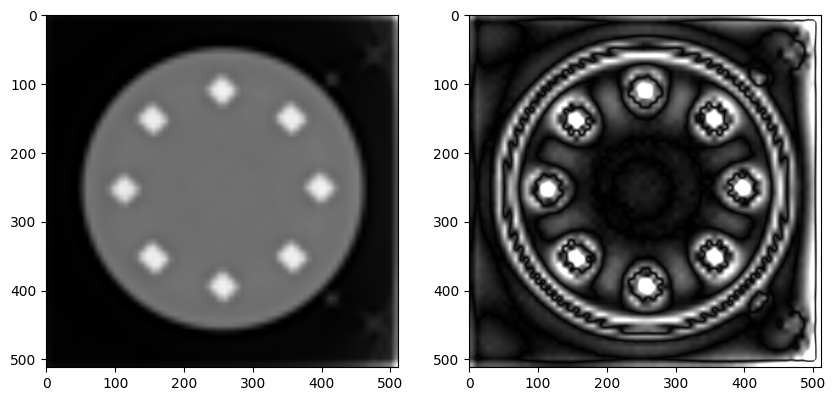

In [32]:
x, step = np.linspace(-nx*dx/2, nx*dx/2, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_B1 = bilinear_value_pixel(xcoords, ycoords, x_B1.reshape(nx, ny))

eval_B1 = eval_B1.reshape((eval_points, eval_points))

f, axarr = plt.subplots(1,2,figsize=(10, 10))
axarr[0].imshow(eval_B1, cmap='gray', vmin = mmin, vmax = mmax)
axarr[1].imshow(np.fabs(eval_B1-eval_B01), cmap='gray', vmin = dmin, vmax = dmax/4)

# Analysis

In [ ]:
for xy in [512, 256, 1024]:
    for nnp, nu in [(900, 855), (360, 855), (1800, 1710)]:
        nx = ny = xy
        dx = dy = 100.0/nx
        du = 25.0/128 * 1710/nu

        sino = np.zeros((nnp, nu))
        y = int(1710/nu)
        x = int(1800/nnp)
        for i in range(int(1710/nu)):
            sino += np.exp(sino_1800_1710_FWHM_noise[::x, i::y]) / y
        
        sino = np.log(sino)

        lsd = 312.5
        lso = 156.25
        angles = np.linspace(0, 2*np.pi, sino.shape[0], endpoint=False, dtype=np.float64)

        A_B0 = A_B0_operator(nx, ny, nnp, nu, dx, dy, du, lsd, lso, angles)
        A_B1 = A_B1_operator(nx, ny, nnp, nu, dx, dy, du, lsd, lso, angles)
        # A_SF = A_SF_operator(nx, ny, nnp, nu, dx, dy, du, lsd, lso, angles)

        iters = np.arange(2, 64)

        print("------------------------------------------------", nx, ny, nnp, nu, "--------------------------------------------------")
        print()

        for epoch in iters:
            x_B0 = pylops.optimization.leastsquares.regularized_inversion(
                A_B0, sino.ravel(), [], engine='pylops', **dict(tol=1e-8, niter=epoch))[0]
            x_B1 = pylops.optimization.leastsquares.regularized_inversion(
                A_B1, sino.ravel(), [], engine='pylops', **dict(tol=1e-8, niter=epoch))[0]
            # x_SF = pylops.optimization.leastsquares.regularized_inversion(
            #     A_SF, sino.ravel(), [], engine='pylops', **dict(tol=1e-8, niter=epoch))[0]

            x, step = np.linspace(-nx*dx/2, nx*dx/2, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
            x += step / 2

            xcoords, ycoords = np.meshgrid(x, np.flip(x))
            
            eval_B0 = pixel_value(xcoords, ycoords, x_B0.reshape(nx, ny)).reshape((eval_points, eval_points))
            # eval_SF = pixel_value(xcoords, ycoords, x_SF.reshape(nx, ny)/6).reshape((eval_points, eval_points))
            eval_B1 = bilinear_value_pixel(xcoords, ycoords, x_B1.reshape(nx, ny)).reshape((eval_points, eval_points))

            SSIM_B0 = ssim(eval_B0, base, data_range = 2.0)
            PSNR_B0 = psnr(eval_B0, base, data_range = 2.0)
            # SSIM_SF = ssim(eval_SF, base, data_range = 2.0)
            # PSNR_SF = psnr(eval_SF, base, data_range = 2.0)
            SSIM_B1 = ssim(eval_B1, base, data_range = 2.0)
            PSNR_B1 = psnr(eval_B1, base, data_range = 2.0)

            RMSE_B0 = np.mean(np.fabs(eval_B0-base)**2)
            # RMSE_SF = np.mean(np.fabs(eval_SF-base)**2)
            RMSE_B1 = np.mean(np.fabs(eval_B1-base)**2)

            print("Epoch #", epoch, sep='')
            print('[B0] PSNR:', PSNR_B0, '\tRMSE:', RMSE_B0, '\tSSIM:', SSIM_B0)
            print('[B1] PSNR:', PSNR_B1, '\tRMSE:', RMSE_B1, '\tSSIM:', SSIM_B1)
            # print('[SF] PSNR:', PSNR_SF, '\tRMSE:', RMSE_SF, '\tSSIM:', SSIM_SF)
            print()


------------------------------------------------32 64 16 8
 512 512 900 855 --------------------------------------------------

Epoch #2
[B0] PSNR: 15.212160857589978 	RMSE: 0.12046029033244347 	SSIM: 0.5810930755302173
[B1] PSNR: 15.20783904524874 	RMSE: 0.1205802241363035 	SSIM: 0.581757855340094

Epoch #3
[B0] PSNR: 17.16884525397454 	RMSE: 0.0767671585407688 	SSIM: 0.6027030526316827
[B1] PSNR: 17.15634901376861 	RMSE: 0.07698836381677521 	SSIM: 0.6047262204212809

Epoch #4
[B0] PSNR: 18.24091957274833 	RMSE: 0.059974693067022224 	SSIM: 0.6472159641541119
[B1] PSNR: 18.220897694085515 	RMSE: 0.06025182720500535 	SSIM: 0.6504835711135085

Epoch #5
[B0] PSNR: 19.93083706424735 	RMSE: 0.0406421135515234 	SSIM: 0.6382124164132299
[B1] PSNR: 19.89539361122946 	RMSE: 0.04097515736993379 	SSIM: 0.6446249155362807

Epoch #6
[B0] PSNR: 21.328502168083077 	RMSE: 0.029458442027168078 	SSIM: 0.7099995220916696
[B1] PSNR: 21.279677105350082 	RMSE: 0.029791493848849243 	SSIM: 0.7216005694998586


In [6]:
from scipy.sparse.linalg import lsmr, lsqr, svds, norm

In [13]:
B0_lg = svds(A_B0_sparse, k=1, which='LM', return_singular_vectors=False, solver='propack')
print(B0_lg)
H0_lg = svds(A_H0_sparse, k=1, which='LM', return_singular_vectors=False, solver='propack')
print(H0_lg)


[1184.701]
[1162.824]


In [ ]:
B0_sm = svds(A_B0_sparse, k=1, which='SM', return_singular_vectors=False, solver='propack')
print(B0_sm)
H0_sm = svds(A_H0_sparse, k=1, which='SM', return_singular_vectors=False, solver='propack')
print(H0_sm)

In [21]:
def radius_power_method(B):
    x = np.random.randn(B.shape[1], 1)
    x = x / np.linalg.norm(x)
    rad = 0

    while True:
        y = B.transpose() @ (B @ x)
        y_norm = np.linalg.norm(y)
        if(abs(rad - y_norm) < power_iterations_tol):
            break
        print("abs(rad - y_norm): ", abs(rad - y_norm))
        rad = y_norm
        x = y / rad
    
    return rad, x

def radius_power_method2(B, trBtB):
    x = np.random.randn(B.shape[1], 1)
    x = x / np.linalg.norm(x)
    rad = 0

    while True:
        y = x - 1/trBtB * (B.transpose() @ (B @ x))
        y_norm = np.linalg.norm(y)
        if(abs(rad - y_norm) < power_iterations_tol):
            break
        print("abs(rad - y_norm): ", abs(rad - y_norm), end='\t')
        rad = y_norm
        x = y / rad
        print(f"Current estimate of gap: {trBtB * (1 - rad)}")
    
    return rad, x

power_iterations_tol = 1e-11

In [18]:
radius, rad_vec = radius_power_method(A_B0_sparse)
trMtM = radius

abs(rad - y_norm):  13924.377722451563
abs(rad - y_norm):  431736.45437456574
abs(rad - y_norm):  313824.3903019978
abs(rad - y_norm):  179901.95095951296
abs(rad - y_norm):  228396.05341692537
abs(rad - y_norm):  153720.91641298425
abs(rad - y_norm):  58719.849233082496
abs(rad - y_norm):  17115.736294181086
abs(rad - y_norm):  4568.927441207925
abs(rad - y_norm):  1190.937091652304
abs(rad - y_norm):  308.59024740732275
abs(rad - y_norm):  79.85080644278787
abs(rad - y_norm):  20.65665742661804
abs(rad - y_norm):  5.343553473940119
abs(rad - y_norm):  1.3823166443035007
abs(rad - y_norm):  0.35759542835876346
abs(rad - y_norm):  0.09250833606347442
abs(rad - y_norm):  0.023931631818413734
abs(rad - y_norm):  0.0061910622753202915
abs(rad - y_norm):  0.0016016173176467419
abs(rad - y_norm):  0.0004143351688981056
abs(rad - y_norm):  0.00010718870908021927
abs(rad - y_norm):  2.7729663997888565e-05
abs(rad - y_norm):  7.173279300332069e-06
abs(rad - y_norm):  1.855660229921341e-06
abs(

KeyboardInterrupt: 

In [19]:
print(trMtM)

1403515.8992169623


In [22]:
min_eigv, min_eigvec = radius_power_method2(A_B0_sparse, trMtM)
spectral_gap = trMtM * (1 - min_eigv)

abs(rad - y_norm):  0.9961055577849114	Current estimate of gap: 5465.911567458591
abs(rad - y_norm):  8.78944492214151e-05	Current estimate of gap: 5342.5503105234175
abs(rad - y_norm):  6.892966031624148e-05	Current estimate of gap: 5245.806436341948
abs(rad - y_norm):  5.854212507006018e-05	Current estimate of gap: 5163.64163303217
abs(rad - y_norm):  5.185316769851234e-05	Current estimate of gap: 5090.864887742545
abs(rad - y_norm):  4.705062021881368e-05	Current estimate of gap: 5024.828594197421
abs(rad - y_norm):  4.334890434720684e-05	Current estimate of gap: 4963.987717732481
abs(rad - y_norm):  4.035698694904166e-05	Current estimate of gap: 4907.346044905009
abs(rad - y_norm):  3.785756845686716e-05	Current estimate of gap: 4854.212345670102
abs(rad - y_norm):  3.571919119382816e-05	Current estimate of gap: 4804.079892922393
abs(rad - y_norm):  3.3856829633416297e-05	Current estimate of gap: 4756.561294234813
abs(rad - y_norm):  3.221243262152562e-05	Current estimate of gap: 4

KeyboardInterrupt: 